In [1]:
import pandas as pd
import numpy as np
from ml_metrics import rmsle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Data
Let's read data from `train.csv` file into memory (assign to `train` variable in our case)

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])

## Questions:
- How many observations (rows) and features (columns) are there?
- What the name and type of **features** (columns)?
- Are there missing values?
- How many memory is use for keep this data in RAM?

## Answers

Use `info` function.
1. there're **10886** samples (`RangeIndex: 10886 entries`)
2. there're **12** features (`Data columns (total 12 columns)`)
3. use a bit more that `1MB` (`memory usage: 1020.6+ KB`)

Example about column name and type:
`datetime      10886 non-null object` means, the name is **datetime** and there're **10886** non-null observations (lookt the first point, all observations is the same number, that means missing values for this column is zero) and `object` means type.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


### Alternative 

In [4]:
print("count samples & features: ", train.shape)
print("Are there missing values: ", train.isnull().values.any())

('count samples & features: ', (10886, 12))
('Are there missing values: ', False)


## Data
https://www.kaggle.com/c/bike-sharing-demand/data

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** -   
    1: Clear, Few clouds, Partly cloudy, Partly cloudy  
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Questions:
1. What is target variable (should be predicted)?
2. What the difference between **count**, **registered** and **casual**?

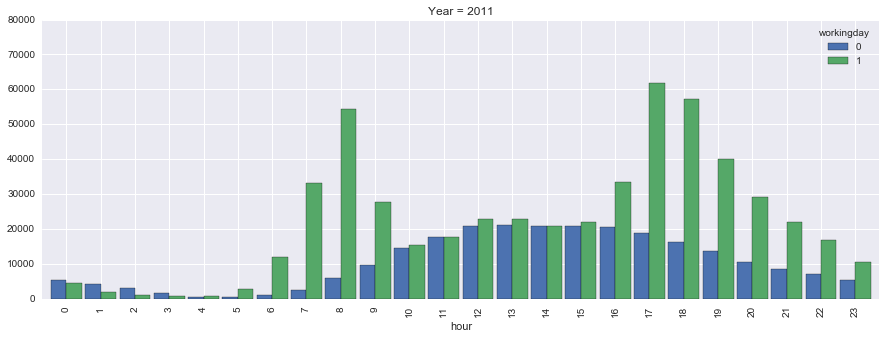

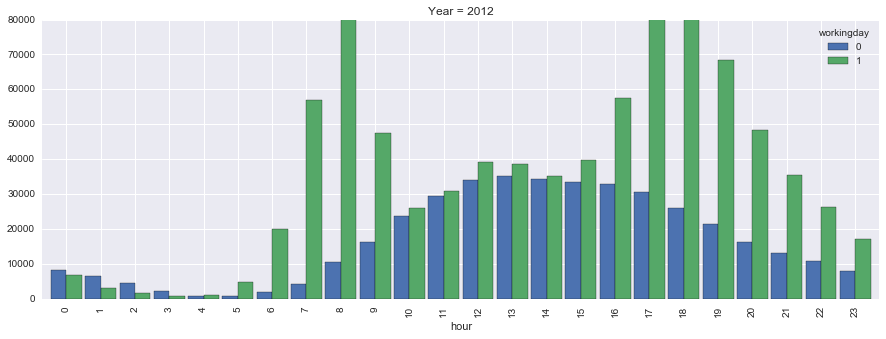

In [7]:
def plot_by_hour(data, year=None, agg='sum'):
    dd = data
    if year: dd = dd[ dd.datetime.dt.year == year ]
    dd.loc[:, ('hour')] = dd.datetime.dt.hour
    
    by_hour = dd.groupby(['hour', 'workingday'])['count'].agg(agg).unstack()
    return by_hour.plot(kind='bar', ylim=(0, 80000), figsize=(15,5), width=0.9, title="Year = {0}".format(year))


plot_by_hour(train, year=2011)
plot_by_hour(train, year=2012)

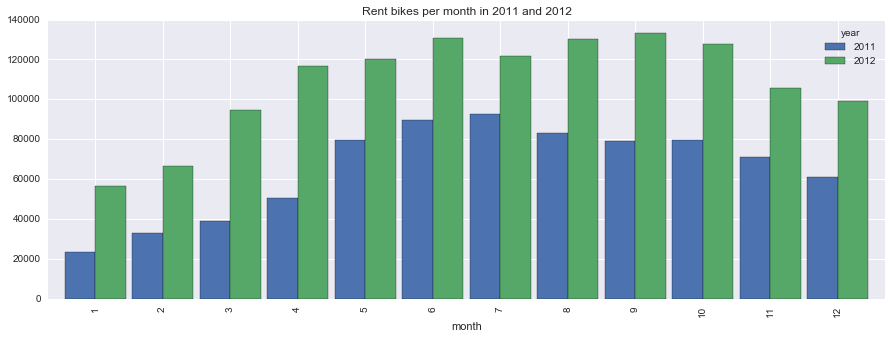

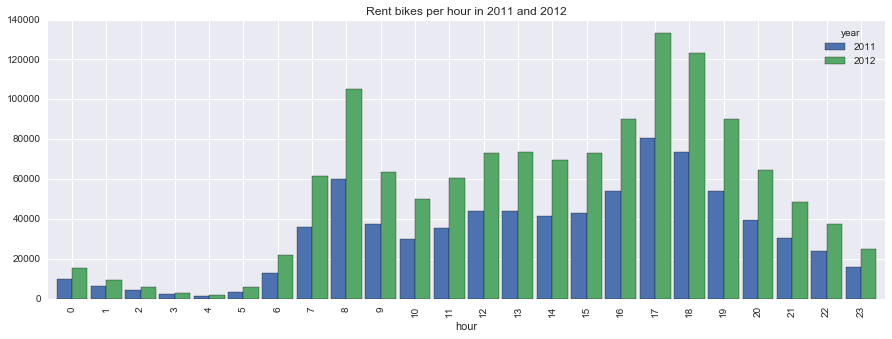

In [8]:
def plot_by_year(agg_attr, title):
    dd = train.copy()
    dd['year'] = train.datetime.dt.year
    dd['month'] = train.datetime.dt.month
    dd['hour'] = train.datetime.dt.hour
    
    by_year = dd.groupby([agg_attr, 'year'])['count'].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15,5), width=0.9, title=title)


plot_by_year('month', "Rent bikes per month in 2011 and 2012")
plot_by_year('hour', "Rent bikes per hour in 2011 and 2012")

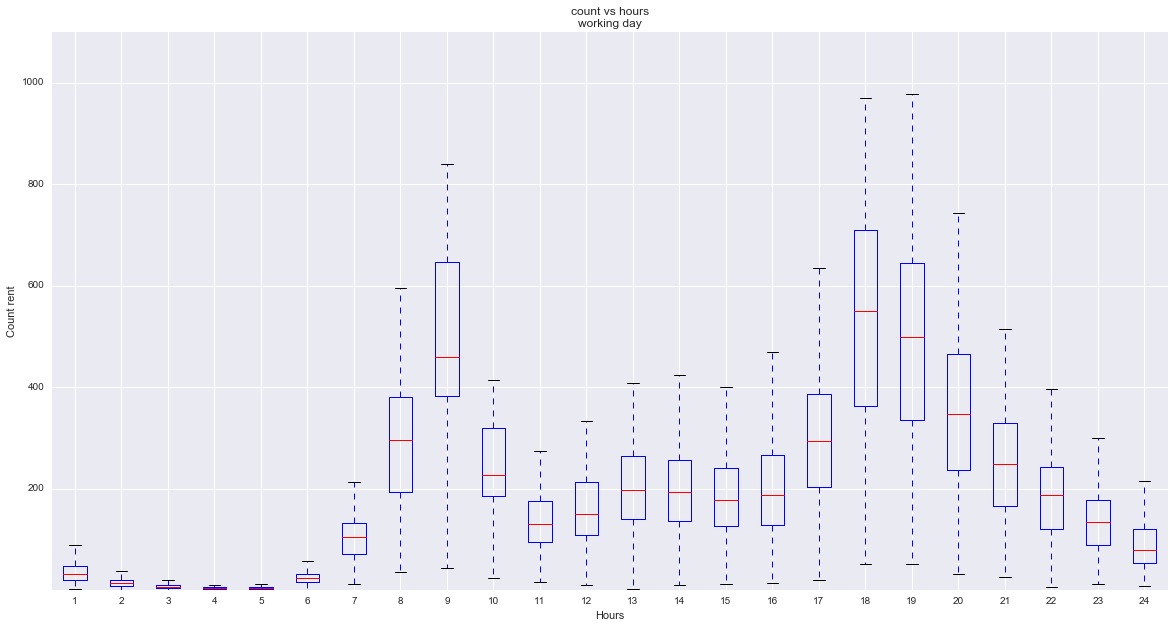

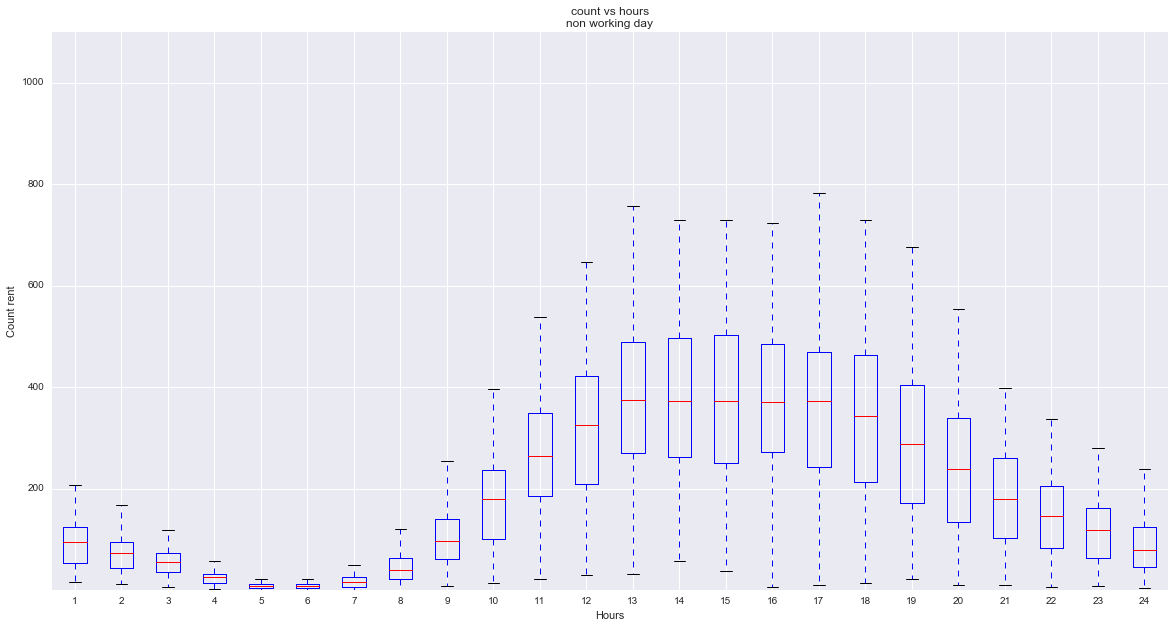

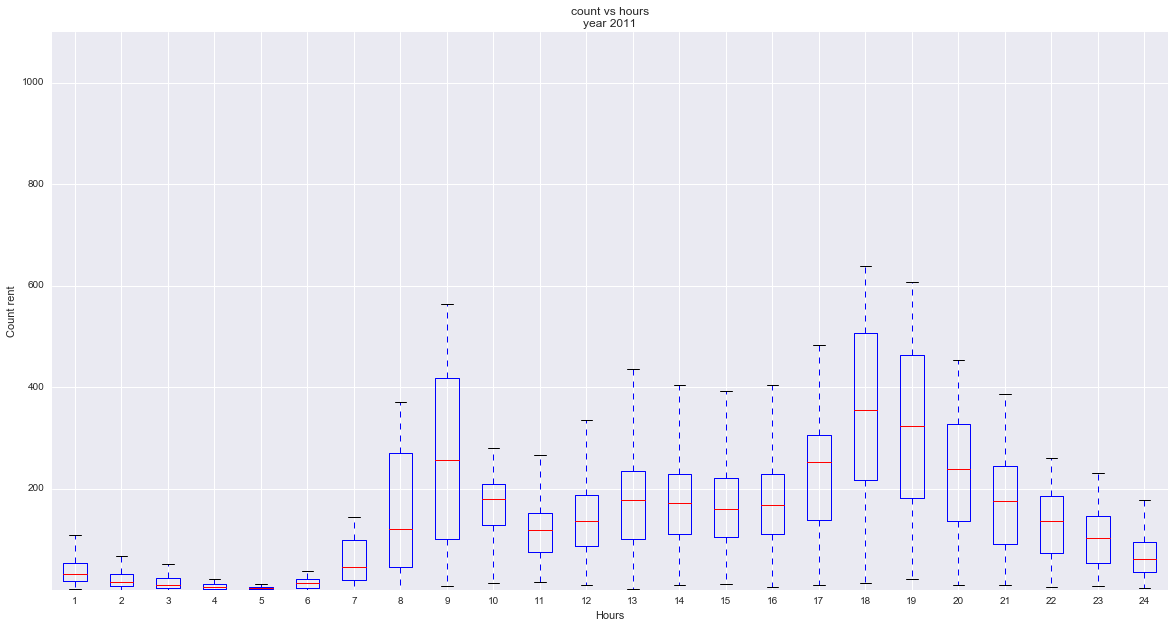

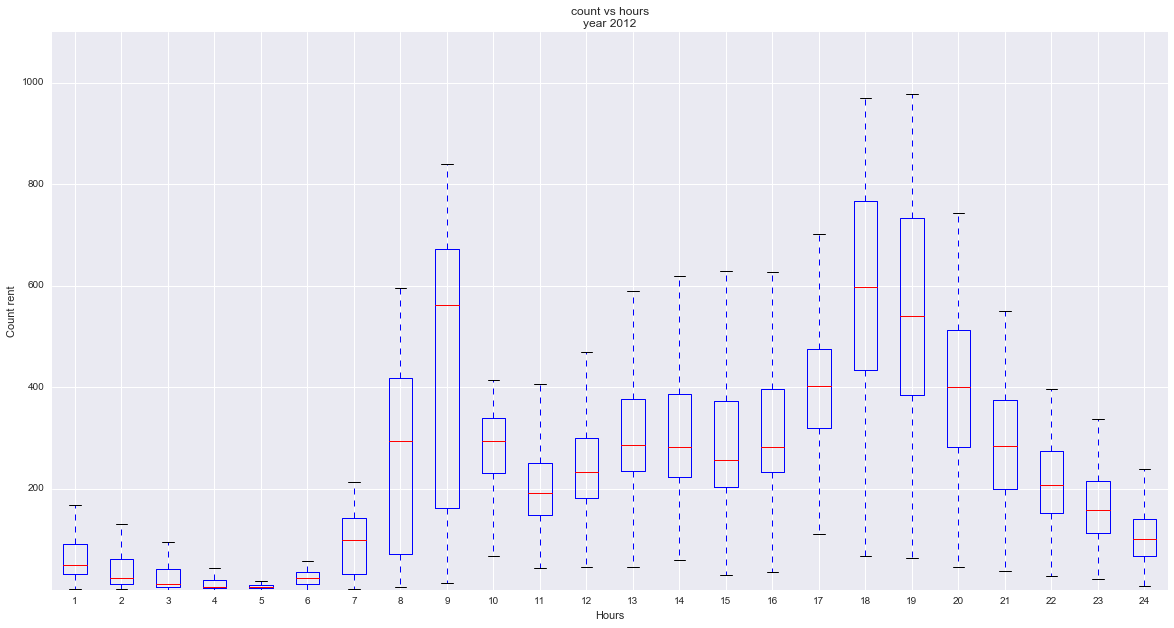

In [9]:
def plot_hours(data, message = ''):
    dd = data.copy()
    dd['hour'] = data.datetime.dt.hour
    
    hours = {}
    for hour in range(24):
        hours[hour] = dd[ dd.hour == hour ]['count'].values

    plt.figure(figsize=(20,10))
    plt.ylabel("Count rent")
    plt.xlabel("Hours")
    plt.title("count vs hours\n" + message)
    plt.boxplot( [hours[hour] for hour in range(24)] )
    
    axis = plt.gca()
    axis.set_ylim([1, 1100])
    

plot_hours( train[train.workingday == 1], 'working day')
plot_hours( train[train.workingday == 0], 'non working day')

plot_hours( train[train.datetime.dt.year == 2011], 'year 2011')
plot_hours( train[train.datetime.dt.year == 2012], 'year 2012')

## Questions
1. What you can say about working and non-working days?
2. What about year: 2011 vs 2012?
3. What the hypothesis do you want assume?

## Metrics

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

where  
**n** is the number of hours in the test set  
**pi** is your predicted count  
**ai** is the actual count  
**log(x)** is the natural logarithm  

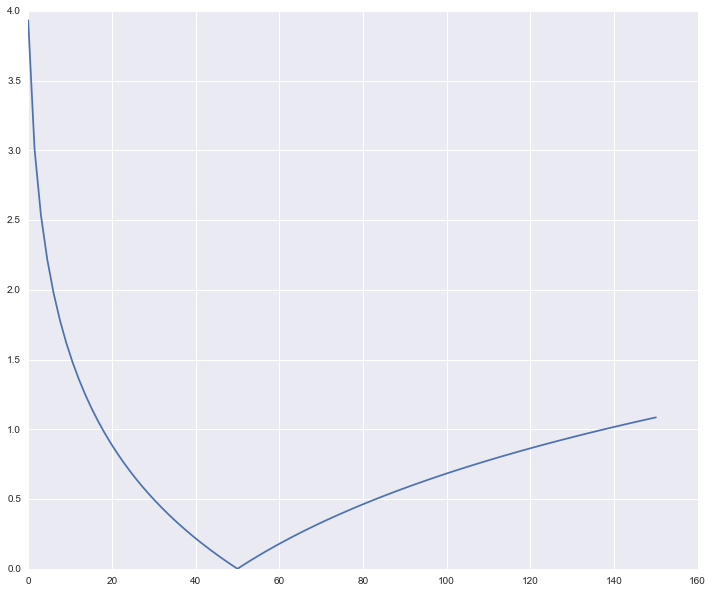

In [10]:
fig = plt.figure(figsize=(12, 10))

y_true = [50]
y_preds = np.linspace(0, 150, 100)

err    = [ rmsle(y_true, [y_pred]) for y_pred in y_preds ]
plt.plot(y_preds, err)

## Questions:
1. What is the ideal value for the metric?
2. How the metric react on outlier (liner or non-linear)?
3. Is there difference for the metric between under/over estimate?